### Business Analysis

This notebook provides steps a business analyst might take to determine which customers are likely to churn. The intention is to compare these analyst predictions to the predictions of a machine learning algorithm for the same data set.


In [2]:
import pandas as pd
import io
import requests
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# # import the telco data as a pandas dataframe
# url = "https://s3.amazonaws.com/h2o-smalldata/TelcoChurn.csv"
# content = requests.get(url).content
# telco_df = pd.read_csv(io.StringIO(content.decode('utf-8')))

# pandas dataframe reads in int and numeric columns correctly except for the 'TotalCharges' column
# use converters to read in 'TotalCharges' as a float, and coerce empty string values to NANs

telco_df = pd.read_csv('https://s3.amazonaws.com/h2o-smalldata/TelcoChurn.csv',
                       converters={'TotalCharges':lambda x: pd.to_numeric(x, errors='coerce')})
# get the type of each column
# telco_df.info()
# get the dataframe dimensions
telco_df.shape

(7043, 21)

In [3]:
# get a list of the column names
column_names = telco_df.columns
# get a list of only the categorical columns (and remove response column)
categorical_feature_list = column_names.drop(["customerID",'tenure','Churn', 'MonthlyCharges','TotalCharges'])
# get a list of only numeric or integer columns
num_feature_list = ['tenure','MonthlyCharges', 'TotalCharges']

# check for missing values in each column
for col in column_names:
    if telco_df[col].isnull().sum() > 0:
        print('number of missing values {0} is {1}'.format(col,telco_df[col].isnull().sum()))

number of missing values TotalCharges is 11


In [4]:
# get the count of people who will churn, the people who wont churn, and the count of people
# were going to churn but didn't because they were sent a coupond (assuming the coupon
# is 30% effective)
# value_counts gives the count of each unique value in the Churn Column 

# change the coupon effectiveness to change the table below
coupon_effectiveness = .3

Churn_Table = pd.DataFrame({'# of People Who Stayed': [telco_df.Churn.value_counts()[0]],
             '# of People Who Churned': [telco_df.Churn.value_counts()[1]],
             "# of People Who Wouldn't Have Churned": [int(telco_df.Churn.value_counts()[1] \
                                           * coupon_effectiveness)]})
Churn_Table
# export Churn_Table to current directory:
# Churn_Table.to_csv('Churn_Table.csv', force=True)

,# of People Who Churned,# of People Who Stayed,# of People Who Wouldn't Have Churned
0,1869,5174,560


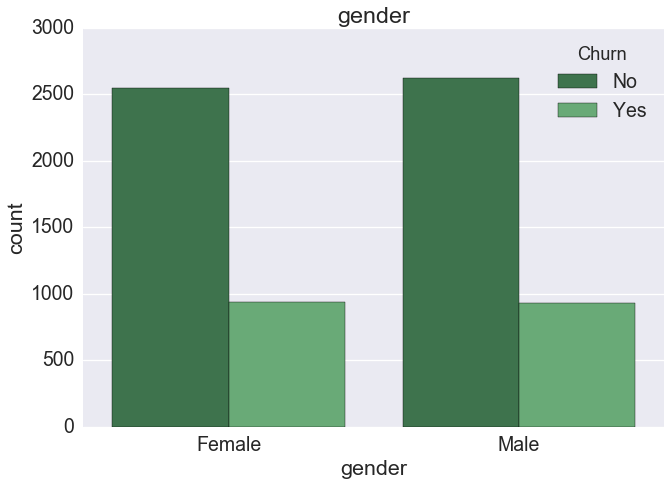

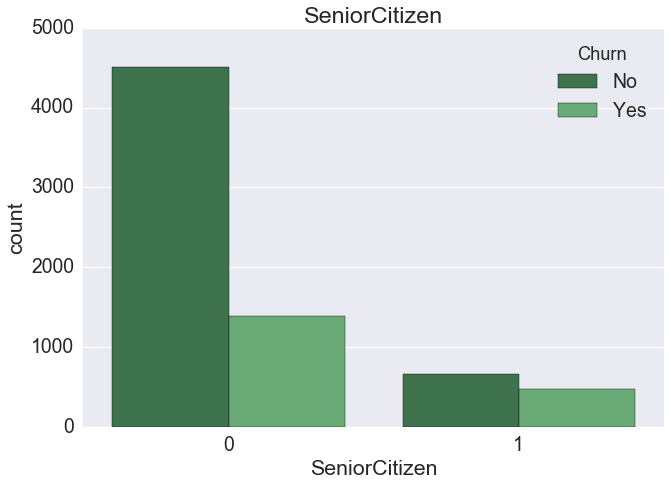

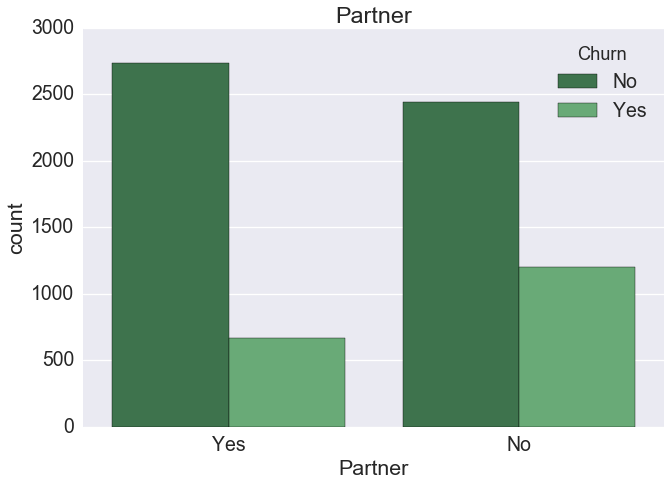

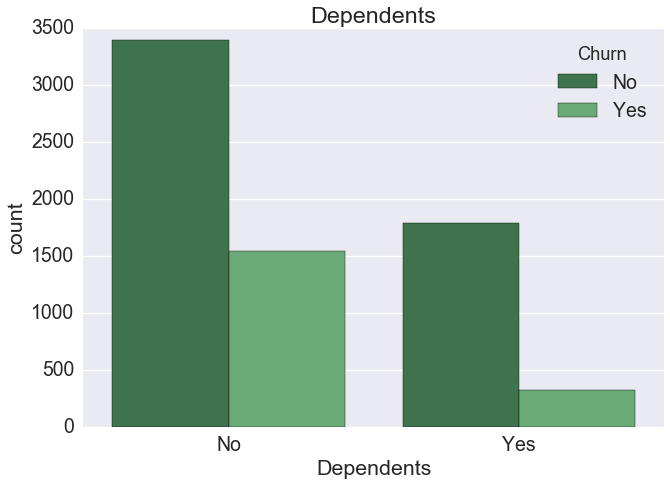

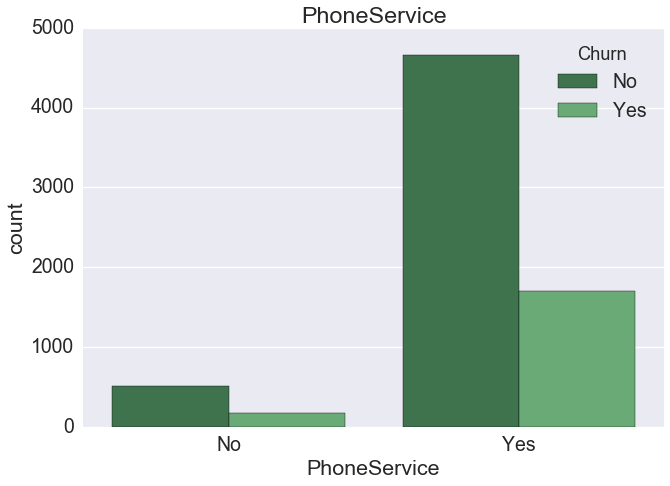

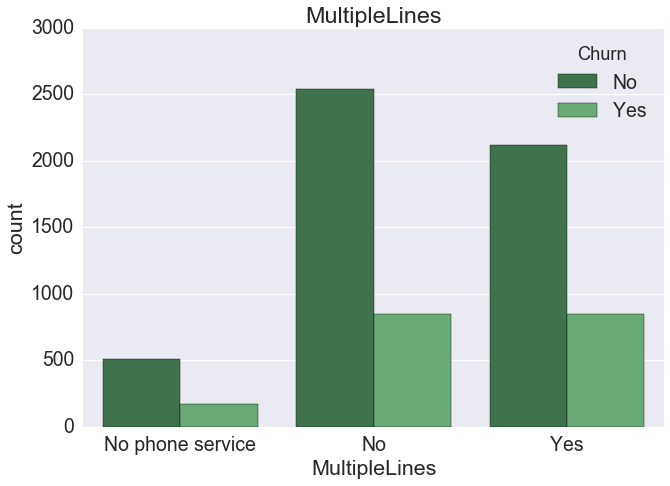

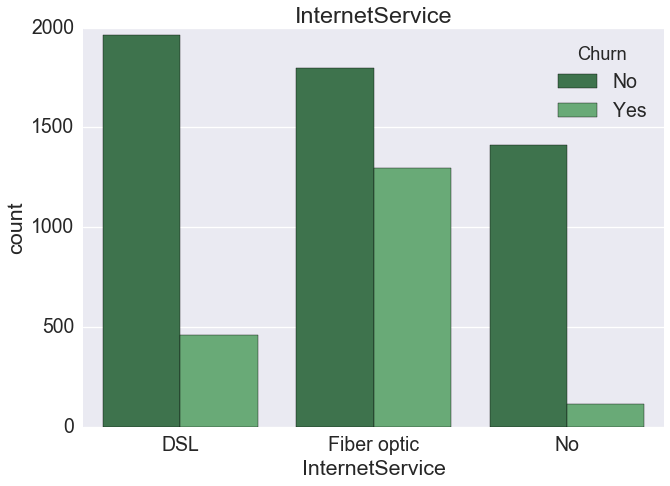

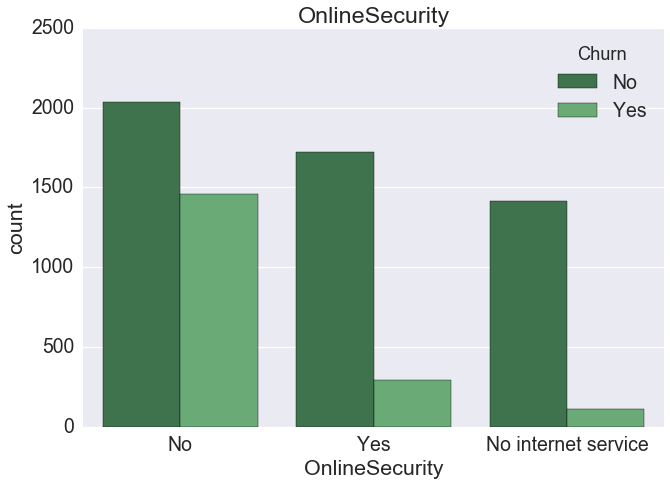

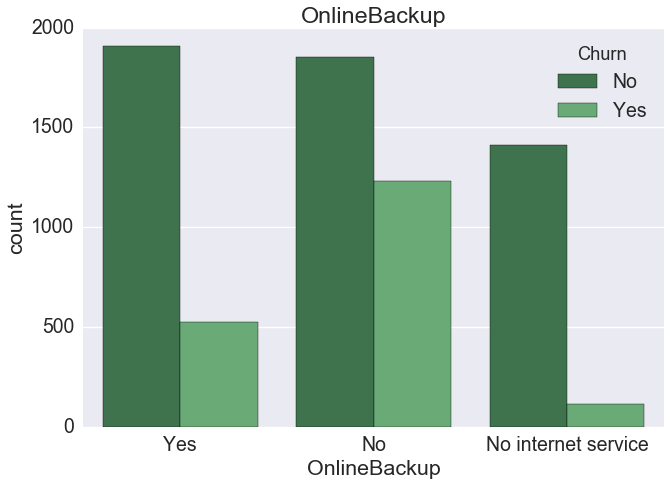

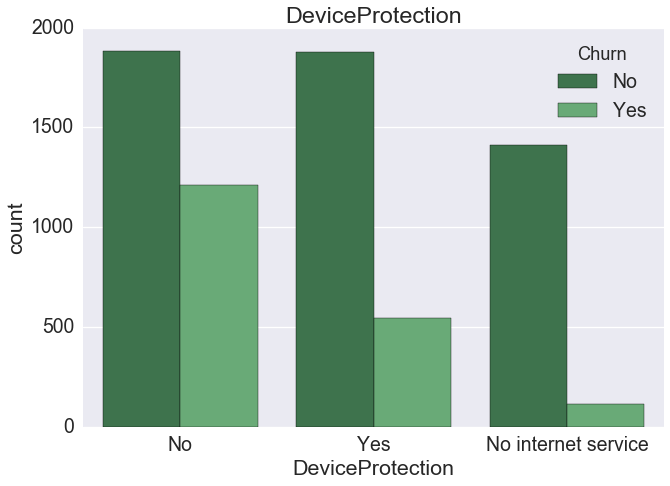

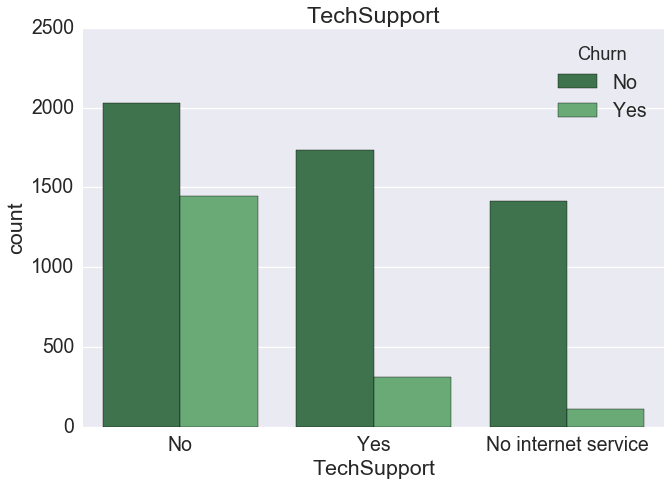

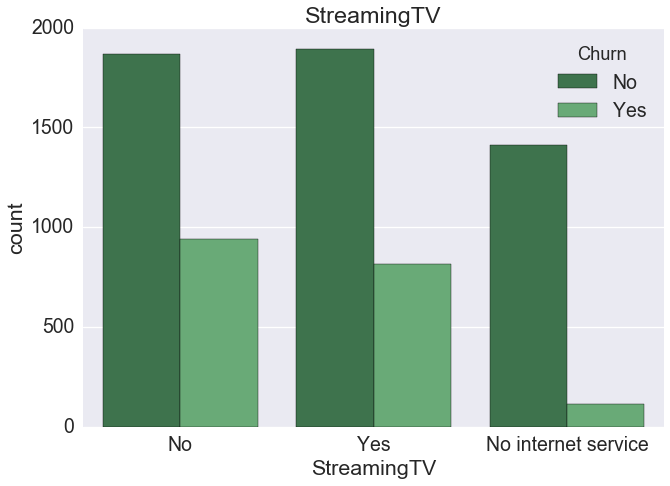

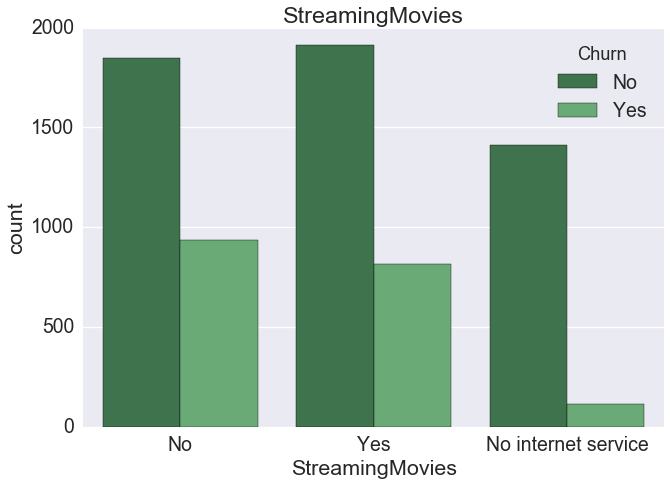

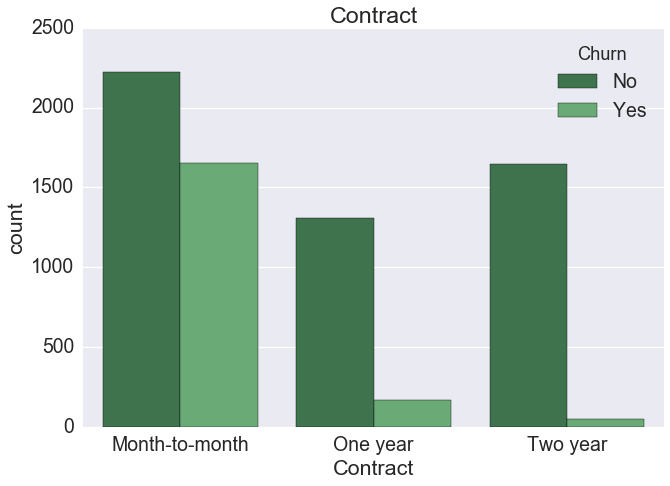

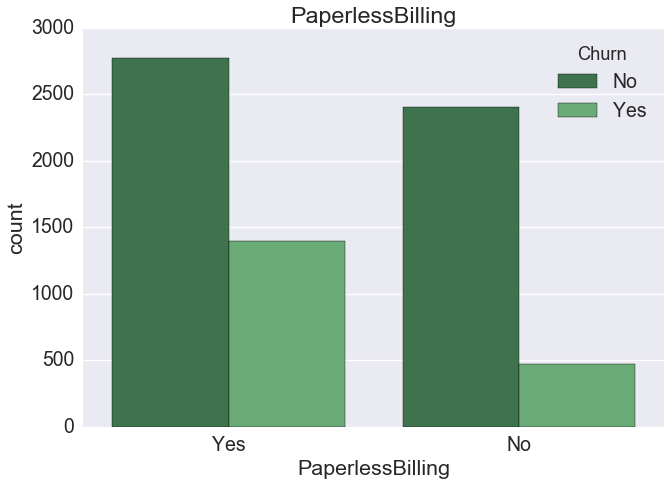

In [5]:
# count plots for all categorical features vs. churn
sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})
for col in categorical_feature_list[:-1]:
    plt.figure()
    sns.countplot(x=col, hue="Churn", data=telco_df, palette="Greens_d");
    plt.title(col)

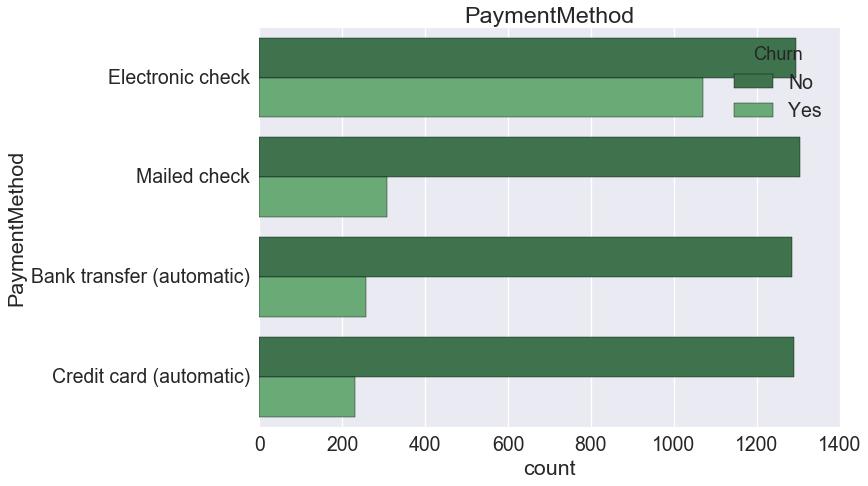

In [6]:
# easier to read if payment methods are listed on the y axis instead of x axis
plt.figure()
sns.countplot(y='PaymentMethod', hue="Churn", data=telco_df, palette="Greens_d");
plt.title('PaymentMethod')

In [7]:
# prepare to plot customer tenure against churn, binning tenure into reasonable chunks
# create tenure bins (metric is in months)
tenure_index = [0,8,16,24,32,40,48,56,64,72]

# get the total counts of people who churned "Yes" within each tenure bin
churn_yes_count = []
churn_yes_count.append(telco_df[(telco_df['tenure'] == 0) & (telco_df['Churn'] == "Yes")].shape[0]) 
for index in tenure_index:   
    churn_yes_count.append(telco_df[((telco_df['tenure'] == index) & (telco_df['tenure'] < index + 8)) & (telco_df['Churn'] == "Yes")].shape[0])    

# get the total counts of people who stayed "No" within each tenure bin
churn_no_count = []
churn_no_count.append(telco_df[(telco_df['tenure'] == 0) & (telco_df['Churn'] == "No")].shape[0])  
for index in tenure_index:
    churn_no_count.append(telco_df[((telco_df['tenure'] == index) & (telco_df['tenure'] < index + 8)) & (telco_df['Churn'] == "No")].shape[0])    


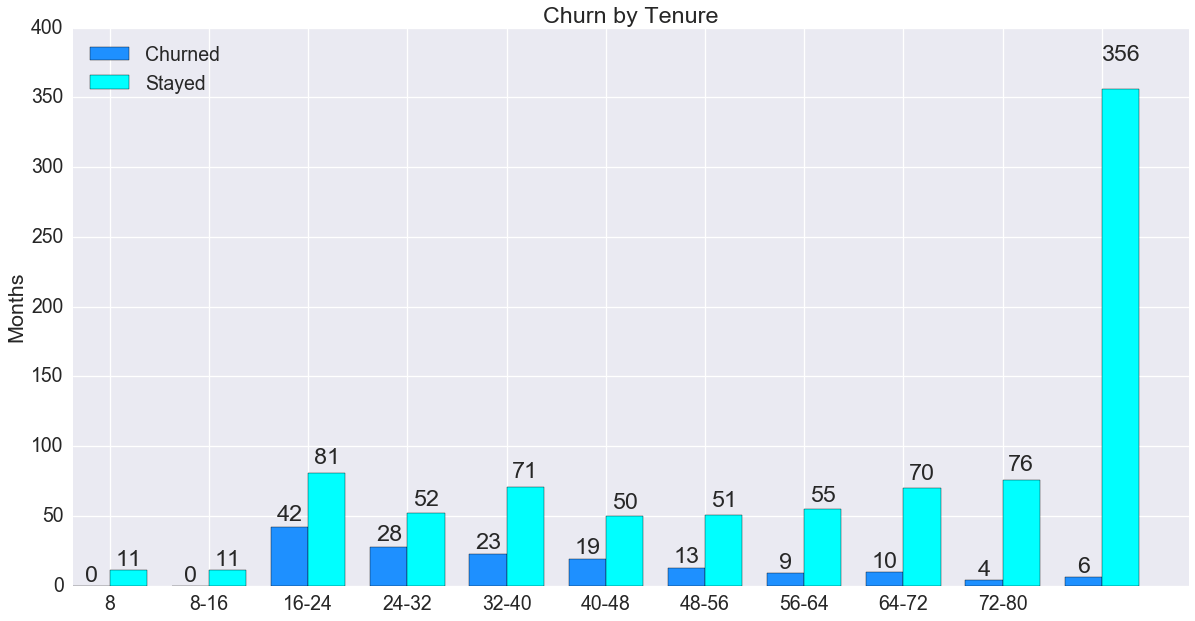

In [8]:
sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})
# provide the x indices and convert to an array
tenure_x_index  = np.array([0,8,16,24,32,40,48,56,64,72,80])
ind = tenure_x_index 

# provide the height values for churn = yes and churn = no
churned_per_bin = churn_yes_count
no_churn_per_bin = churn_no_count

# the width of the bars
width = 3       

# create the figures and plot axis
fig, ax = plt.subplots(figsize=(20, 10))
plt.figure(figsize=(20,10))
rects1 = ax.bar(ind, churned_per_bin, width, color='dodgerblue')
rects2 = ax.bar(ind + width, no_churn_per_bin, width, color='cyan')

#add labels
ax.set_ylabel('Counts')
ax.set_ylabel('Months')
ax.set_title('Churn by Tenure')
ax.set_xticks(ind + width)
ax.set_xticklabels(('8','8-16', '16-24', '24-32', '32-40',
                   '40-48','48-56','56-64' 
                   ,'64-72','72-80'))
ax.legend((rects1[0], rects2[0]), ('Churned', 'Stayed'),loc='upper left')


def autolabel(rects):
    # attach some text labels
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()


In [9]:
# get number of unique values and types of each column
for col in column_names:
    print(col, telco_df[col].nunique())
    if telco_df[col].nunique() < 5:
        #print(col, telco_df[col].unique())
        None

('customerID', 7043)
('gender', 2)
('SeniorCitizen', 2)
('Partner', 2)
('Dependents', 2)
('tenure', 73)
('PhoneService', 2)
('MultipleLines', 3)
('InternetService', 3)
('OnlineSecurity', 3)
('OnlineBackup', 3)
('DeviceProtection', 3)
('TechSupport', 3)
('StreamingTV', 3)
('StreamingMovies', 3)
('Contract', 3)
('PaperlessBilling', 2)
('PaymentMethod', 4)
('MonthlyCharges', 1585)
('TotalCharges', 6530)
('Churn', 2)


In [10]:
# get a sense of the unique types of monthly charges, by rounding floats to integers
feature_data = telco_df["MonthlyCharges"]
print('max:',max(feature_data))
print('min:', min(feature_data))

# round the monthly charges to get a sense of how many unique monthly charges there are
int_feature = feature_data.apply(int)
unique_charges = int_feature .nunique()
print(int_feature .nunique()) 

('max:', 118.75)
('min:', 18.25)
99


('max:', 8684)
('min:', 0)


(array([ 1192.,   573.,   447.,   356.,   336.,   313.,   314.,   251.,
          227.]),
 array([   0,  200,  400,  600,  800, 1000, 1200, 1400, 1600, 1800]),
 <a list of 9 Patch objects>)

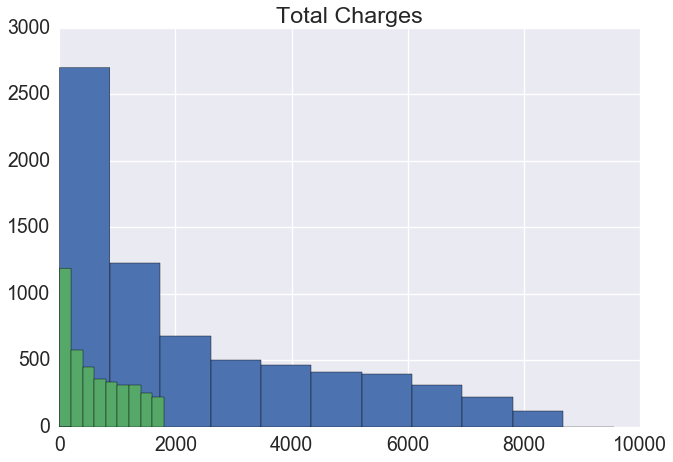

In [11]:
sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})
# create bins for monthly and total charges, based off the min and max and then create a histogram
# replace na values with 0 for the Total Charges which has 11 missing values (these can be calculated and filled later)
feature_data = telco_df["TotalCharges"].fillna(0)
int_feature = feature_data.apply(int)
print('max:',int(max(feature_data)))
print('min:', int(min(feature_data)))
max_feature = int(max(feature_data))
min_feature = int(min(feature_data))
num_of_bins = 10
binwidth =  (max_feature - min_feature)/num_of_bins
plt.hist(int_feature, bins=range(min_feature, max_feature + binwidth, binwidth))
plt.title("Total Charges")

# focus on the lower end of total changes, limit to the max value where the drop off plateaus
set_max_value = 2000
num_of_bins = 10
binwidth =  (set_max_value - min_feature)/num_of_bins
plt.hist(int_feature, bins=range(min_feature, set_max_value, binwidth))

('max:', 118)
('min:', 18)


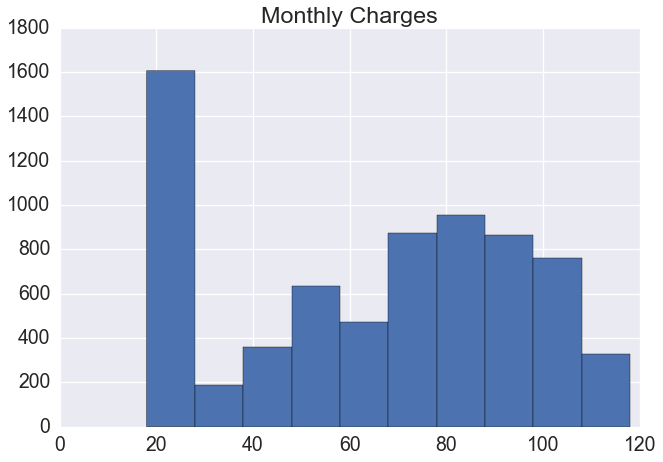

In [12]:
sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})
# create bins for monthly and total charges, based off the min and max and then create a histogram
# replace na values with 0 for the Total Charges which has 11 missing values (these can be calculated and filled later)
feature_data = telco_df["MonthlyCharges"]
int_feature = feature_data.apply(int)
print('max:',int(max(feature_data)))
print('min:', int(min(feature_data)))
max_feature = int(max(feature_data))
min_feature = int(min(feature_data))
num_of_bins = 10
binwidth =  (max_feature - min_feature)/num_of_bins
plt.hist(int_feature, bins=range(min_feature, max_feature + binwidth, binwidth))
plt.title("Monthly Charges")
# # focus on the lower end of total changes, limit to the max value where the drop off plateaus
# set_max_value = 2000
# num_of_bins = 10
# binwidth =  (set_max_value - min_feature)/num_of_bins
# plt.hist(int_feature, bins=range(min_feature, set_max_value, binwidth))

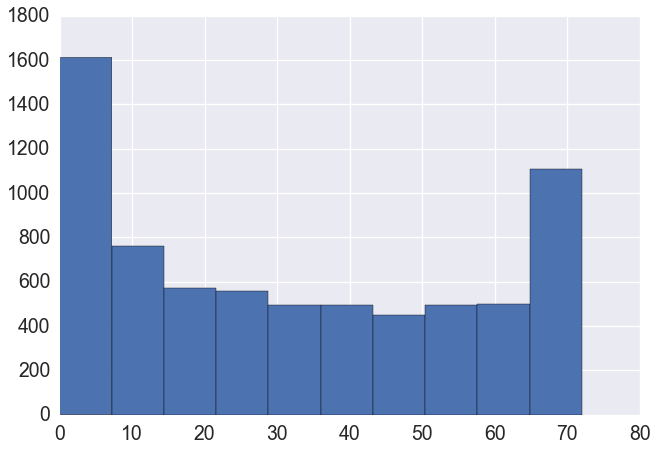

In [13]:
sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})
# get histogram of tenure (how long a person has been a customer in months)
telco_df['tenure'].hist()

In [14]:
# # to do: figure out why crosstab tables are off
# # create a definition that prints out frequency count tables (pandas crosstab) for each column
# def crosstab_freq_table(column_name,dataset):
#     crosstab_table = pd.crosstab(index = dataset[column_name], columns="frequency count") 
#     return crosstab_table/crosstab_table.sum()


# # create a definition that allows you to create a crosstab table with two variables and includes row/column tallies
# # setting margins = True includes the row and column totals
# def crosstab_two_var(index, column, dataset):
#     """get the pandas crosstab table with two variables, the column sets the tables columns
#     the index sets the tables index, margins = True provides row and column totals"""
#     two_var =  pd.crosstab(index = dataset[index], 
#                            columns = dataset[column],
#                            margins=True)   
    
#     # set the columns and indexs to the unique values found in each feature column, and add row/column totals
#     two_var.columns = list(telco_df[column].unique())+ ["rowtotal"]
#     two_var.index = list(telco_df[index].unique())+ ["coltotal"]
#     # divide the table by the grand total to get the total proportion of counts in each cell 
# #     two_var_proportion = two_var.ix[:,0:2]/two_var.ix["coltotal"][:-1]
# #     two_var_proportion["rowtotal"] = two_var["rowtotal"]/two_var.ix["coltotal"][:-1]
# #     two_var_proportion = two_var/two_var.ix["coltotal"]
# #     return two_var_proportion
#     return two_var
#     # comment the line above, and uncomment the line below to get the counts instead of proportions
#     #return two_var

# # create a crosstab table for three variables

# def crosstab_three(index, col_1, col_2, dataset):
#     crosstab_three_var = pd.crosstab(index =dataset[index], 
#                                  columns=[dataset[col_1],
#                                           dataset[col_2]],
#                                  margins=True)   # Include row and column totals

#     return crosstab_three_var

# # create a crosstab for four tables

# def crosstab_four(index, col_1, col_2, col_3, dataset):
#     crosstab_four_var = pd.crosstab(index =dataset[index], 
#                                  columns=[dataset[col_1],
#                                           dataset[col_2],
#                                           dataset[col_3]],
#                                  margins=True)   # Include row and column totals

#     return crosstab_four_var

# crosstab_three("Churn", "Contract", "PaymentMethod", telco_df)
# # crosstab_four("Churn", "Contract", "PaymentMethod", "InternetService", telco_df)

# # To do: significance testing
# # get the proportions of those who churn within each level for all of the categorical variables
# # removed row total, could add it back?
# for col in categorical_feature_list:
#     print "==========================="
#     print "Churn vs.", col
#     print "==========================="
#     print crosstab_two_var("Churn", col, telco_df)
#     print "==========================="

In [15]:
# print out tables that break down which levels indicate churn within each feature (column)
for col in categorical_feature_list:
    print "Churn vs.", col
    print "==========================="
    print telco_df.groupby([col])['Churn'].value_counts()
    print "==========================="
    print "==========================="

Churn vs. gender
gender  Churn
Female  No       2549
        Yes       939
Male    No       2625
        Yes       930
Name: Churn, dtype: int64
Churn vs. SeniorCitizen
SeniorCitizen  Churn
0              No       4508
               Yes      1393
1              No        666
               Yes       476
Name: Churn, dtype: int64
Churn vs. Partner
Partner  Churn
No       No       2441
         Yes      1200
Yes      No       2733
         Yes       669
Name: Churn, dtype: int64
Churn vs. Dependents
Dependents  Churn
No          No       3390
            Yes      1543
Yes         No       1784
            Yes       326
Name: Churn, dtype: int64
Churn vs. PhoneService
PhoneService  Churn
No            No        512
              Yes       170
Yes           No       4662
              Yes      1699
Name: Churn, dtype: int64
Churn vs. MultipleLines
MultipleLines     Churn
No                No       2541
                  Yes       849
No phone service  No        512
                  Yes  

In [16]:
# Set the values of interest here:

# categorical dictionary of values that seem correlated with Churn:
# the dictionary is created to you can check if a feature is equal to a churn correlated level
cat_dict = {
    'gender': [], # gender does seem correlated with churn
    'SeniorCitizen': [1], # younger people are less likely to churn 
    'Partner':['Yes'], 
    'Dependents': ["No"],
    'PhoneService': [],
    'MultipleLines':["Yes"], # not a strong indicator, but maybe more lines means people need the best deal 
    'PaperlessBilling': ['Yes'],
    'InternetService': ["Fiber optic"],
    'OnlineSecurity' : ['No'],
    'OnlineBackup': ['Yes'],
    'DeviceProtection': ['No'],
    'TechSupport': ['No'],
    'StreamingTV': ['No'],
    'StreamingMovies': ['No'],
    'Contract': ['Month-to-month'],
    'PaperlessBilling': ['No'],
    'PaymentMethod': ["Bank transfer (automatic)"]
    
}


# numerical dictionary of cut off values for Churn correlation:
num_dict = {
    'tenure': [telco_df['tenure'].mean()],
    'MonthlyCharges': [telco_df['MonthlyCharges'].mean()],
    'TotalCharges': [telco_df['TotalCharges'].mean()]
}


# feature list: the list of columns that you believe are correlated with churn
# important_feature_list = ["tenure", 'Contract', 'PaymentMethod']
important_feature_list = ["tenure", 'TechSupport']

In [17]:
# # This version is hard coded to be used with 'tenure' 
# # change the values in this line (instead of 20 and 11) to see different results:
# # boolean_df[column] = dataframe[column].map(lambda x: True if x <= (20) and (x >= 11) else False)
# def boolean_matrix(important_features,dataframe,categorical_dict, numerical_dict, threshold = None):
#     if threshold == None:
#         threshold = len(important_features)
#     boolean_df = pd.DataFrame()
#     # subset the dataframe to only consider the important feature columns
#     dataframe = dataframe[important_features]
#     for column in dataframe.columns:
#         if type(dataframe[column][0]) == str:
#             boolean_df[column] = dataframe[column].isin(categorical_dict[column])
        
#         elif (type(dataframe[column][0]) == np.int64) or (type(dataframe[column][0]) == np.float64):
#             boolean_df[column] = dataframe[column].map(lambda x: True if x <= (20) and (x >= 11) else False)
#         else:
#             print "something went wrong"
#     # sum over all the 1s and 0s to get a count of features that correlated with churn
#     # if sum of row is equal to the length of important_feature set equal to "Yes" they will churn
#     print boolean_df.head()
#     new_column = boolean_df.sum(axis=1).map(lambda x: "Yes" if x >= threshold else "No")
#     # convert the pandas series into a dataframe
#     new_column = pd.DataFrame(new_column)
#     # set the column title to predicted_churn
#     new_column.columns = ['predicted_churn']
#     return new_column

In [18]:
# Use this definition
def boolean_matrix(important_features,dataframe,categorical_dict, numerical_dict, threshold = None):
    """returns a boolean column with True if a row contained the values in the categorical dictionary
    or less than the values given in the numerical dictionary, returns False if the row does not contain
    the same values as the dictionaries in one or more of the features given in 'important_features' list."""
    
    if threshold == None:
        threshold = len(important_features)
    boolean_df = pd.DataFrame()
    # subset the dataframe to only consider the important feature columns
    dataframe = dataframe[important_features]
    for column in dataframe.columns:
        if type(dataframe[column][0]) == str:
            boolean_df[column] = dataframe[column].isin(categorical_dict[column])
        
        elif (type(dataframe[column][0]) == np.int64) or (type(dataframe[column][0]) == np.float64):
            boolean_df[column] = dataframe[column].map(lambda x: True if x <= numerical_dict[column][0] else False)
        else:
            print "something went wrong"
    # sum over all the 1s and 0s to get a count of features that correlated with churn
    # if sum of row is equal to the length of important_feature set equal to "Yes" they will churn
    print boolean_df.head()
    new_column = boolean_df.sum(axis=1).map(lambda x: "Yes" if x >= threshold else "No")
    # convert the pandas series into a dataframe
    new_column = pd.DataFrame(new_column)
    # set the column title to predicted_churn
    new_column.columns = ['predicted_churn']
    return new_column


In [19]:
# important_feature_list = ["tenure", 'PaymentMethod']
important_feature_list = ["tenure"]
# update inputs a few cells above
new_col = boolean_matrix(important_feature_list,telco_df,cat_dict, num_dict, threshold = 2)

# print out the true/false results for the rule based predicted churn column
telco_df['predicted_churn'] = new_col

telco_df.head()

  tenure
0   True
1  False
2   True
3  False
4   True


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,predicted_churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,No,No,No,One year,No,Mailed check,56.95,1889.50,No,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,No
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,No


In [21]:
from sklearn.metrics import accuracy_score
y_true = telco_df['Churn'].map(lambda x: 1 if x == "Yes" else 0)
y_scores = telco_df['predicted_churn'].map(lambda x: 1 if x == "Yes" else 0)
print 'accuracy score', accuracy_score(y_true, y_scores)

accuracy score 0.734630129206


In [20]:
# # get the auc score for each column
# from sklearn.metrics import roc_auc_score
# y_true = 
# y_scores = 
# print 'the AUC Score', roc_auc_score(y_true, y_scores)